In [1]:
from typing import *

import librosa
import numpy as np
from numpy.fft import rfft
from numpy import pi
from matplotlib import pyplot as plt
from IPython.display import Audio
import cmath
import scipy
from scipy.signal import stft

from cache_no_hash import cache
from blindDescend import blindDescend
from yin import yin
from harmonicSynth import HarmonicSynth, Harmonic

TWO_PI = np.pi * 2

c:\Users\iGlop\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
PAGE_LEN = 1024
SR = 22050
DTYPE = np.float32
N_HARMONICS = 8

In [3]:
HANN = scipy.signal.get_window('hann', PAGE_LEN, True)
IMAGINARY_LADDER = np.linspace(0, TWO_PI * 1j, PAGE_LEN)
SPECTRUM_SIZE = PAGE_LEN // 2 + 1
NYQUIST = SR // 2

In [4]:
def sino(freq, length):
    return np.sin(np.arange(length) * freq * TWO_PI / SR)

def playHard(data, sr=SR):
    return Audio(data, rate = sr)
def play(data, soft = .1, sr = SR):
    t = np.concatenate([data, [1]])
    length = round(soft * sr)
    t[:length ] = np.multiply(t[:length ], np.linspace(0, 1, length))
    t[-length:] = np.multiply(t[-length:], np.linspace(1, 0, length))
    return playHard(t, sr)

def findPeaks(energy):
    slope = np.sign(energy[1:] - energy[:-1])
    extrema = slope[1:] - slope[:-1]
    return np.argpartition(
        (extrema == -2) * energy[1:-1], - N_HARMONICS,
    )[- N_HARMONICS:] + 1

def sft(signal, freq_bin):
    # Slow Fourier Transform
    return np.abs(np.sum(signal * np.exp(IMAGINARY_LADDER * freq_bin))) / PAGE_LEN

def refineGuess(guess, signal):
    def loss(x):
        if x < 0:
            return 0
        return - sft(signal, x)
    freq_bin, loss_ = blindDescend(loss, .01, .4, guess)
    return freq_bin * SR / PAGE_LEN, - loss_

def widePlot(h = 3, w = 12):
    plt.gcf().set_size_inches(w, h)
    
def spectrum(signal, do_wide = True, trim = 130):
    energy = np.abs(rfft(signal * HANN))
    X = np.linspace(0, SR / 2, len(energy))
    plt.plot(
        X     [:trim], 
        energy[:trim], 
    )
    plt.xlabel('freq (Hz)')
    if do_wide:
        widePlot()

def spectrogram(signal, **kw):
    f, t, Zxx = stft(signal, fs=SR, **kw)
    plt.pcolormesh(t, f, np.abs(Zxx))

def concatSynth(synth, harmonics, n):
    buffer = []
    for i in range(n):
        synth.eat(harmonics)
        buffer.append(synth.mix())
    return np.concatenate(buffer)

def pitch2freq(pitch):
    return np.exp((pitch + 36.37631656229591) * 0.0577622650466621)

def freq2pitch(f):
    return np.log(f) * 17.312340490667562 - 36.37631656229591

def pagesOf(signal):
    for i in range(0, signal.size - PAGE_LEN + 1, PAGE_LEN):
        yield signal[i : i + PAGE_LEN]

def plotUnstretchedPartials(f0, n_partials = 14, color = 'r', alpha = .3):
    for i in range(1, n_partials + 1):
        freq = f0 * i
        plt.axvline(x = freq, color = color, alpha = alpha)


In [5]:
y, sr = librosa.load(r"C:\Users\iGlop\d\temp\2.wav")
print('sr =', sr)
assert sr == SR

sr = 22050


In [6]:
do = y[int(SR * .3) : int(SR * 1.2)]
play(do)

In [7]:
do_freq = pitch2freq(60)
print(f'{do_freq = }')
play(sino(do_freq, SR))

do_freq = 261.6255653005984


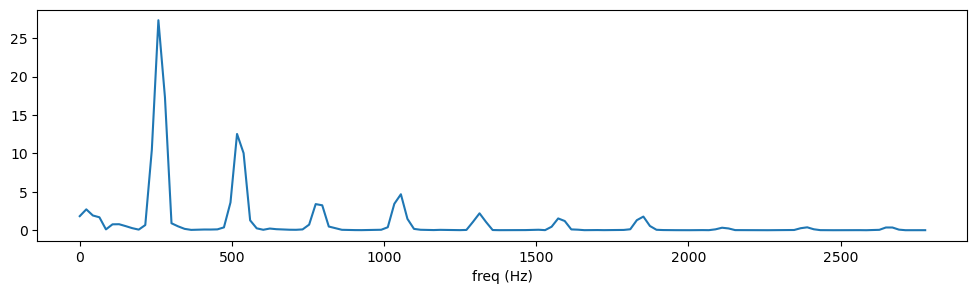

In [8]:
spectrum(do[int(len(do) * .5):][:PAGE_LEN])

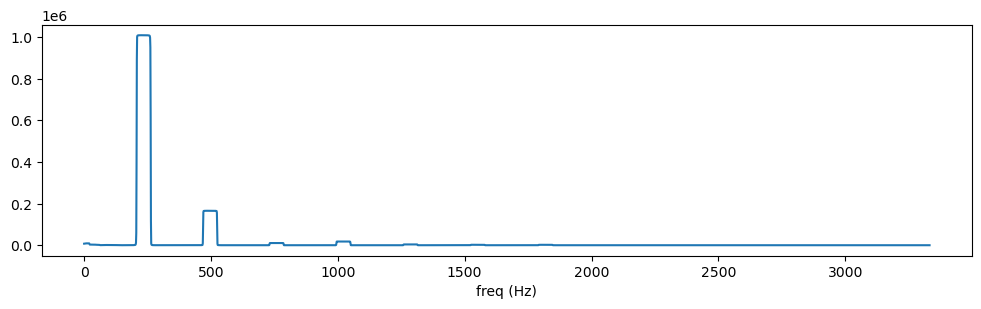

In [9]:
def plotSpec2():
    trim = 3000
    energy = np.abs(rfft(do * scipy.signal.get_window(
        'hann', len(do), True
    )))
    X = np.linspace(0, SR / 2, len(energy))
    sqe = energy ** 2
    collate = 50
    Y = np.zeros(len(sqe) - collate)
    for i in range(collate):
        Y += sqe[i : -collate + i]
    plt.plot(
        X[:trim], 
        Y[:trim], 
    )
    plt.xlabel('freq (Hz)')
    widePlot()
    # plt.ylim(0, 1e5)
plotSpec2()

In [10]:
LOOKUP = np.array([1, 0.17, 0.01, 0.02, 0.005, 0.005, 0.005, 0.0001]) ** 0.5
LOOKUP

array([1.        , 0.41231056, 0.1       , 0.14142136, 0.07071068,
       0.07071068, 0.07071068, 0.01      ])

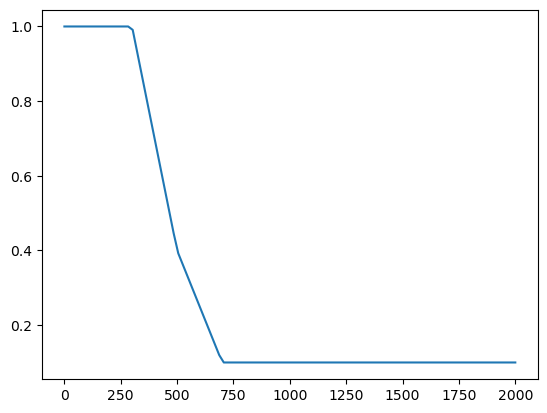

In [11]:
def timbre(freq):
    if freq < 300:
        return 1.0
    if freq < 500:
        return 1.0 - (freq - 300) / 200 * 0.6
    if freq < 700:
        return 0.4 - (freq - 500) / 200 * 0.3
    return 0.1
X = np.linspace(0, 2000, 100)
plt.plot(X, [timbre(x) for x in X])

In [12]:
def f():
    hS = HarmonicSynth(N_HARMONICS, SR, PAGE_LEN, np.float32, True, False)
    amp = 1.0
    buf = []
    for _ in range(20):
        harmonics = []
        for h_i in range(N_HARMONICS):
            try:
                strength = LOOKUP[h_i]
            except IndexError:
                strength = LOOKUP[-1]
            harmonics.append(Harmonic(do_freq * (h_i + 1), amp * strength))
        hS.eat(harmonics)
        buf.append(hS.mix())
        amp *= 0.8
    return play(np.concatenate(buf))
f()

In [13]:
def f():
    hS = HarmonicSynth(N_HARMONICS, SR, PAGE_LEN, np.float32, True, False)
    amp = 1.0
    buf = []
    for _ in range(20):
        harmonics = []
        for h_i in range(N_HARMONICS):
            freq = do_freq * (h_i + 1)
            harmonics.append(Harmonic(freq, amp * timbre(freq)))
        hS.eat(harmonics)
        buf.append(hS.mix())
        amp *= 0.8
    return play(np.concatenate(buf))
f()

In [14]:
from piano import keySpectrogram, spectrogramToAudio, SR as PIANO_SR

In [19]:
z = keySpectrogram(60)
# play(z, sr=PIANO_SR)
play(spectrogramToAudio(z), sr=PIANO_SR)

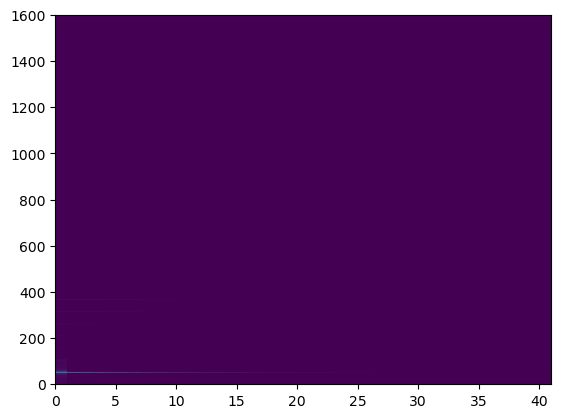

In [20]:
plt.pcolormesh(z)